In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import jieba.posseg as pseg
from keras import layers
from keras.layers import LSTM, Dense, Dropout, Input, Embedding, Flatten, Conv1D, MaxPooling1D
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [5]:
data = pd.read_csv('data_1_20.csv')
data = data[data.Label.isin([1,2,5,6,7,9,10,11,12,13])]
data = data.dropna()
data = data.replace({10:0,11:3,12:4,13:8})
data

,Text,Label
0,偶像是工作 渣男是生活 我 就 渣,3.0
3,就4好,3.0
5,我就省,3.0
7,我爛我驕傲,3.0
8,按讚的都是裸考king,3.0
...,...,...
9880,普(ㄇㄚˊ)通(ㄍㄨㄚ)人 請問你是駭客嗎?,0.0
9881,請問這是標準聯盟嗎?,0.0
9883,這是假期嗎？ 被工作摧殘的我,0.0
9884,這是一隻青蛙嗎？,0.0


In [6]:
def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([word for word, flag in words if flag != 'x' and flag != 'eng'])

In [7]:
data['Text_tokenized'] = data.Text.apply(jieba_tokenizer)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.982 seconds.
Prefix dict has been built successfully.


In [8]:
import keras
MAX_NUM_WORDS = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data.Text_tokenized)
x_data = tokenizer.texts_to_sequences(data.Text_tokenized)

In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
max_seq_len = max([len(seq) for seq in x_data])
print(max_seq_len)

71


In [10]:
MAX_SEQUENCE_LENGTH = 70
x_data = keras.preprocessing.sequence.pad_sequences(x_data, maxlen=MAX_SEQUENCE_LENGTH)
x_data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 1502,    5,  248,  824,  572,    5,
        388,    2,    8,  824], dtype=int32)

In [11]:
y_data = data.Label
y_data = np_utils.to_categorical(y_data)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.05)

### CNN 10-class

In [ ]:
NUM_EMBEDDING_DIM = 1024
NUM_CLASSES = 10

In [ ]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(input_dim=MAX_NUM_WORDS, output_dim=NUM_EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True)(inputs)
x = Dropout(0.5)(embedding)
x = Conv1D(512, kernel_size = 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Flatten()(x)
outputs = Dense(units=NUM_CLASSES, activation='softmax')(x)

In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=30, validation_split=0.2,
    callbacks = ModelCheckpoint('my_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'))

Epoch 1/30
21/21 [==============================] - 3s 137ms/step - loss: 2.1460 - accuracy: 0.2534 - val_loss: 1.8777 - val_accuracy: 0.3765
Epoch 2/30
21/21 [==============================] - 3s 128ms/step - loss: 1.5804 - accuracy: 0.4618 - val_loss: 1.5718 - val_accuracy: 0.4588
Epoch 3/30
21/21 [==============================] - 3s 149ms/step - loss: 1.1575 - accuracy: 0.6279 - val_loss: 1.3708 - val_accuracy: 0.5046
Epoch 4/30
21/21 [==============================] - 4s 180ms/step - loss: 0.7488 - accuracy: 0.7985 - val_loss: 1.2555 - val_accuracy: 0.5732
Epoch 5/30
21/21 [==============================] - 3s 156ms/step - loss: 0.4116 - accuracy: 0.9034 - val_loss: 1.2040 - val_accuracy: 0.6006
Epoch 6/30
21/21 [==============================] - 3s 161ms/step - loss: 0.2005 - accuracy: 0.9607 - val_loss: 1.2251 - val_accuracy: 0.6067
Epoch 7/30
21/21 [==============================] - 3s 130ms/step - loss: 0.1041 - accuracy: 0.9821 - val_loss: 1.2580 - val_accuracy: 0.6174
Epoch 

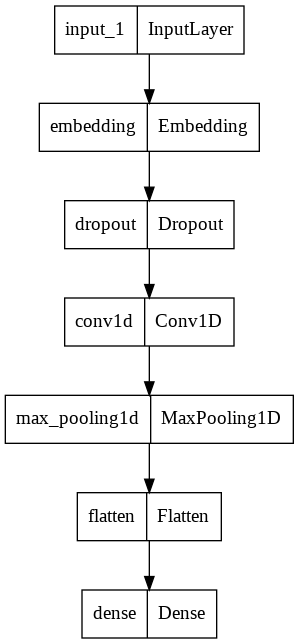

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

#### test

In [ ]:
model = keras.models.load_model('my_model.h5')

In [ ]:
test=pd.DataFrame(data={'Text':['沒有搶到免運的你', '奇怪的知識增加了']})
test['Text_tokenized'] = test.Text.apply(jieba_tokenizer)

In [ ]:
tokenizer.fit_on_texts(test.Text_tokenized)
test = tokenizer.texts_to_sequences(test.Text_tokenized)
test = keras.preprocessing.sequence.pad_sequences(test, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
pred = model.predict(test)

In [ ]:
np.argmax(pred, axis=1)

array([1, 2])

### CNN 6-class

In [ ]:
NUM_EMBEDDING_DIM = 512
NUM_CLASSES = 12

In [ ]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(input_dim=MAX_NUM_WORDS, output_dim=NUM_EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True)(inputs)
x = Dropout(0.5)(embedding)
x = Conv1D(128, kernel_size = 3, activation='relu')(x)
#x = Dropout(0.3)(x)
x = MaxPooling1D()(x)
#x = Conv1D(256, kernel_size = 3, activation='relu')(x)
#x = MaxPooling1D()(x)
#x = Concatenate(axis=1)([x1, x2])
x = Flatten()(x)

outputs = Dense(units=NUM_CLASSES, activation='softmax')(x)

#model.summary()

In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=30, validation_split=0.2)

Epoch 1/30
13/13 [==============================] - 2s 56ms/step - loss: 1.9276 - accuracy: 0.1767 - val_loss: 1.6908 - val_accuracy: 0.3047
Epoch 2/30
13/13 [==============================] - 0s 32ms/step - loss: 1.6213 - accuracy: 0.3282 - val_loss: 1.5708 - val_accuracy: 0.3145
Epoch 3/30
13/13 [==============================] - 0s 31ms/step - loss: 1.3858 - accuracy: 0.4945 - val_loss: 1.3014 - val_accuracy: 0.5479
Epoch 4/30
13/13 [==============================] - 0s 29ms/step - loss: 1.0720 - accuracy: 0.6650 - val_loss: 1.0281 - val_accuracy: 0.6339
Epoch 5/30
13/13 [==============================] - 1s 39ms/step - loss: 0.8159 - accuracy: 0.7377 - val_loss: 0.9154 - val_accuracy: 0.6708
Epoch 6/30
13/13 [==============================] - 0s 31ms/step - loss: 0.6282 - accuracy: 0.8147 - val_loss: 0.8220 - val_accuracy: 0.7002
Epoch 7/30
13/13 [==============================] - 0s 28ms/step - loss: 0.4647 - accuracy: 0.8824 - val_loss: 0.7936 - val_accuracy: 0.7199
Epoch 8/30
13

In [ ]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 1.0690 - accuracy: 0.7212


[1.0690027475357056, 0.721238911151886]

### CNN + LSTM

In [42]:
NUM_EMBEDDING_DIM = 1024
NUM_LSTM_UNITS = 128
NUM_CLASSES = 10

In [45]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(input_dim=MAX_NUM_WORDS, output_dim=NUM_EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True)(inputs)
x = Dropout(0.5)(embedding)
x = Conv1D(128, kernel_size = 3, activation='relu')(x)
x = MaxPooling1D()(x)
lstm = LSTM(NUM_LSTM_UNITS)
x = lstm(x)

outputs = Dense(units=NUM_CLASSES, activation='softmax')(x)

In [46]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=30, validation_split=0.2)

Epoch 1/30
21/21 [==============================] - 4s 80ms/step - loss: 2.1453 - accuracy: 0.2718 - val_loss: 1.9054 - val_accuracy: 0.3567
Epoch 2/30
21/21 [==============================] - 1s 47ms/step - loss: 1.5989 - accuracy: 0.4508 - val_loss: 1.5369 - val_accuracy: 0.4527
Epoch 3/30
21/21 [==============================] - 1s 47ms/step - loss: 1.1208 - accuracy: 0.6344 - val_loss: 1.3815 - val_accuracy: 0.5412
Epoch 4/30
21/21 [==============================] - 1s 48ms/step - loss: 0.6668 - accuracy: 0.8031 - val_loss: 1.3224 - val_accuracy: 0.5716
Epoch 5/30
21/21 [==============================] - 1s 47ms/step - loss: 0.3296 - accuracy: 0.9202 - val_loss: 1.3832 - val_accuracy: 0.5960
Epoch 6/30
21/21 [==============================] - 1s 49ms/step - loss: 0.1597 - accuracy: 0.9618 - val_loss: 1.4543 - val_accuracy: 0.6067
Epoch 7/30
21/21 [==============================] - 1s 48ms/step - loss: 0.0880 - accuracy: 0.9821 - val_loss: 1.5687 - val_accuracy: 0.5991
Epoch 8/30
21

In [28]:
model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 19ms/step - loss: 1.7174 - accuracy: 0.6358


[1.7174016237258911, 0.6358381509780884]

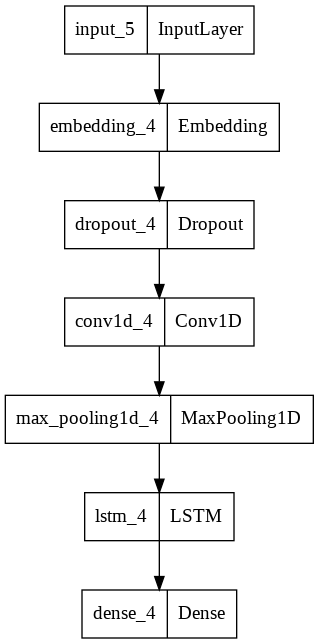

In [29]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

### CNN 10-class

In [ ]:
NUM_EMBEDDING_DIM = 1024
NUM_CLASSES = 10

In [ ]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(input_dim=MAX_NUM_WORDS, output_dim=NUM_EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True)(inputs)
x = Dropout(0.5)(embedding)
x = Conv1D(512, kernel_size = 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Flatten()(x)
outputs = Dense(units=NUM_CLASSES, activation='softmax')(x)

In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=30, validation_split=0.2,
    callbacks = ModelCheckpoint('my_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'))

Epoch 1/30
21/21 [==============================] - 6s 225ms/step - loss: 2.1431 - accuracy: 0.2744 - val_loss: 1.8887 - val_accuracy: 0.3841
Epoch 2/30
21/21 [==============================] - 3s 129ms/step - loss: 1.5723 - accuracy: 0.4668 - val_loss: 1.5511 - val_accuracy: 0.4665
Epoch 3/30
21/21 [==============================] - 3s 128ms/step - loss: 1.1383 - accuracy: 0.6405 - val_loss: 1.3794 - val_accuracy: 0.5427
Epoch 4/30
21/21 [==============================] - 3s 129ms/step - loss: 0.7175 - accuracy: 0.8065 - val_loss: 1.3307 - val_accuracy: 0.5503
Epoch 5/30
21/21 [==============================] - 3s 126ms/step - loss: 0.3828 - accuracy: 0.9137 - val_loss: 1.3041 - val_accuracy: 0.6006
Epoch 6/30
21/21 [==============================] - 3s 127ms/step - loss: 0.1854 - accuracy: 0.9607 - val_loss: 1.3183 - val_accuracy: 0.6082
Epoch 7/30
21/21 [==============================] - 3s 129ms/step - loss: 0.0971 - accuracy: 0.9832 - val_loss: 1.3770 - val_accuracy: 0.6128
Epoch 

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 70)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 70, 1024)          10240000  
                                                                 
 dropout_1 (Dropout)         (None, 70, 1024)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 68, 512)           1573376   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 34, 512)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 17408)             0         
                                                           

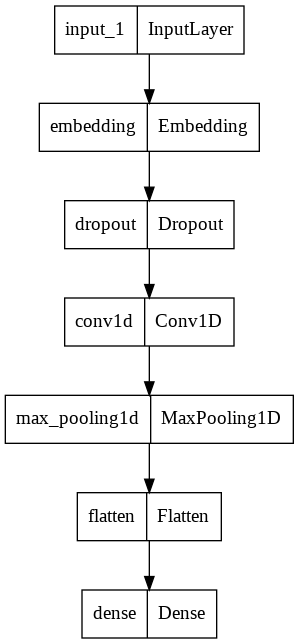

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

#### test

In [ ]:
model = keras.models.load_model('my_model.h5')

In [ ]:
test=pd.DataFrame(data={'Text':['沒有搶到免運的你', '奇怪的知識增加了']})
test['Text_tokenized'] = test.Text.apply(jieba_tokenizer)

In [ ]:
tokenizer.fit_on_texts(test.Text_tokenized)
test = tokenizer.texts_to_sequences(test.Text_tokenized)
test = keras.preprocessing.sequence.pad_sequences(test, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
pred = model.predict(test)

In [ ]:
np.argmax(pred, axis=1)

array([1, 2])

### CNN 6-class

In [ ]:
NUM_EMBEDDING_DIM = 512
NUM_CLASSES = 12

In [ ]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(input_dim=MAX_NUM_WORDS, output_dim=NUM_EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True)(inputs)
x = Dropout(0.5)(embedding)
x = Conv1D(128, kernel_size = 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Flatten()(x)
outputs = Dense(units=NUM_CLASSES, activation='softmax')(x)

In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=30, validation_split=0.2)

Epoch 1/30
13/13 [==============================] - 2s 56ms/step - loss: 1.9276 - accuracy: 0.1767 - val_loss: 1.6908 - val_accuracy: 0.3047
Epoch 2/30
13/13 [==============================] - 0s 32ms/step - loss: 1.6213 - accuracy: 0.3282 - val_loss: 1.5708 - val_accuracy: 0.3145
Epoch 3/30
13/13 [==============================] - 0s 31ms/step - loss: 1.3858 - accuracy: 0.4945 - val_loss: 1.3014 - val_accuracy: 0.5479
Epoch 4/30
13/13 [==============================] - 0s 29ms/step - loss: 1.0720 - accuracy: 0.6650 - val_loss: 1.0281 - val_accuracy: 0.6339
Epoch 5/30
13/13 [==============================] - 1s 39ms/step - loss: 0.8159 - accuracy: 0.7377 - val_loss: 0.9154 - val_accuracy: 0.6708
Epoch 6/30
13/13 [==============================] - 0s 31ms/step - loss: 0.6282 - accuracy: 0.8147 - val_loss: 0.8220 - val_accuracy: 0.7002
Epoch 7/30
13/13 [==============================] - 0s 28ms/step - loss: 0.4647 - accuracy: 0.8824 - val_loss: 0.7936 - val_accuracy: 0.7199
Epoch 8/30
13

In [ ]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 1.0690 - accuracy: 0.7212


[1.0690027475357056, 0.721238911151886]

### CNN + LSTM

In [ ]:
NUM_EMBEDDING_DIM = 512
NUM_LSTM_UNITS = 32
NUM_CLASSES = 12

In [ ]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(input_dim=MAX_NUM_WORDS, output_dim=NUM_EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True)(inputs)
x = Dropout(0.5)(embedding)
x = Conv1D(128, kernel_size = 3, activation='relu')(x)
x = MaxPooling1D()(x)
lstm = LSTM(NUM_LSTM_UNITS)
x = lstm(x)

outputs = Dense(units=NUM_CLASSES, activation='softmax')(x)

In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=30, validation_split=0.2)

Epoch 1/30
13/13 [==============================] - 6s 118ms/step - loss: 2.2435 - accuracy: 0.2328 - val_loss: 2.0454 - val_accuracy: 0.2776
Epoch 2/30
13/13 [==============================] - 0s 34ms/step - loss: 1.8871 - accuracy: 0.3608 - val_loss: 1.7249 - val_accuracy: 0.4595
Epoch 3/30
13/13 [==============================] - 0s 31ms/step - loss: 1.5154 - accuracy: 0.5554 - val_loss: 1.3629 - val_accuracy: 0.6216
Epoch 4/30
13/13 [==============================] - 0s 32ms/step - loss: 1.1188 - accuracy: 0.7112 - val_loss: 1.0824 - val_accuracy: 0.6364
Epoch 5/30
13/13 [==============================] - 0s 33ms/step - loss: 0.8169 - accuracy: 0.7802 - val_loss: 0.9385 - val_accuracy: 0.7101
Epoch 6/30
13/13 [==============================] - 0s 29ms/step - loss: 0.5663 - accuracy: 0.8750 - val_loss: 0.8537 - val_accuracy: 0.7199
Epoch 7/30
13/13 [==============================] - 0s 28ms/step - loss: 0.3801 - accuracy: 0.9329 - val_loss: 0.8230 - val_accuracy: 0.7346
Epoch 8/30
1

In [ ]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 16ms/step - loss: 1.1384 - accuracy: 0.7168


[1.1383858919143677, 0.7168141603469849]